## cross-correlation

In [1]:
#| code-summary: "import stuff"
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()  # datetime converter for a matplotlib
import seaborn as sns
sns.set(style="ticks", font_scale=1.5)
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from datetime import datetime as dt
from scipy import signal
import math
import scipy
import statsmodels.api as sm

from ipywidgets import interact, IntSlider
from IPython.display import display, HTML


# %matplotlib widget

In [2]:
delta_t = 0.1
time = np.arange(0, 50, delta_t)
N = len(time)
period = 10.0
time_offset = scipy.constants.golden
omega = math.tau / period
signal1 = 3.0 + np.sin(omega*time) + 0.1 * np.random.random(N)
signal2 = -0.5 + 0.2 * np.sin(omega*time - math.tau * (time_offset/period)) + 0.2 * np.random.random(N)

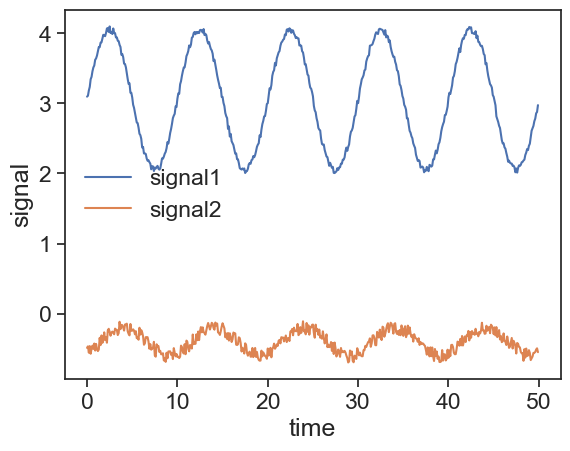

In [3]:
fig, ax = plt.subplots()
ax.plot(time, signal1, label="signal1")
ax.plot(time, signal2, label="signal2")
ax.set(xlabel="time",
       ylabel="signal")
ax.legend(frameon=False)

In [4]:
def norm_data(data):
    """
    normalize data to have mean=0 and standard_deviation=1
    """
    return (data - data.mean())/ data.std()

s1 = norm_data(signal1)
s2 = norm_data(signal2)

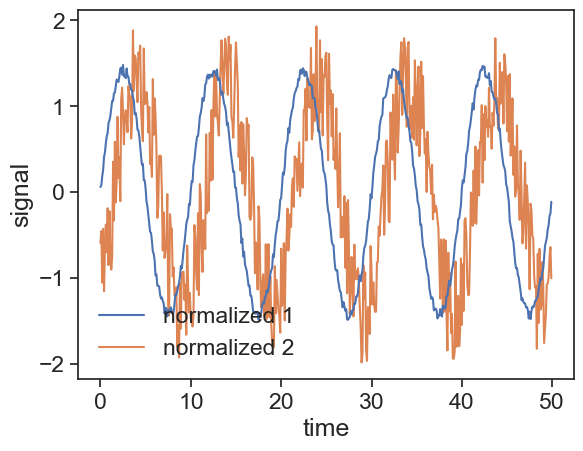

In [5]:
fig, ax = plt.subplots()
ax.plot(time, s1, label="normalized 1")
ax.plot(time, s2, label="normalized 2", zorder=0)
ax.set(xlabel="time",
       ylabel="signal")
ax.legend(frameon=False)

In [6]:

def ncc(data0, data1):
    """
    normalized cross-correlation coefficient between two data sets

    Parameters
    ----------
    data0, data1 :  numpy arrays of same size
    """
    return (1.0/(data0.size-1)) * np.sum(norm_data(data0)*norm_data(data1))

[Text(0.5, 0, 'lag (pts)'),
 Text(0, 0.5, 'cross correlation function'),
 Text(0.5, 1.0, 's2 is best correlated with s1 when shifted by -15 pts')]

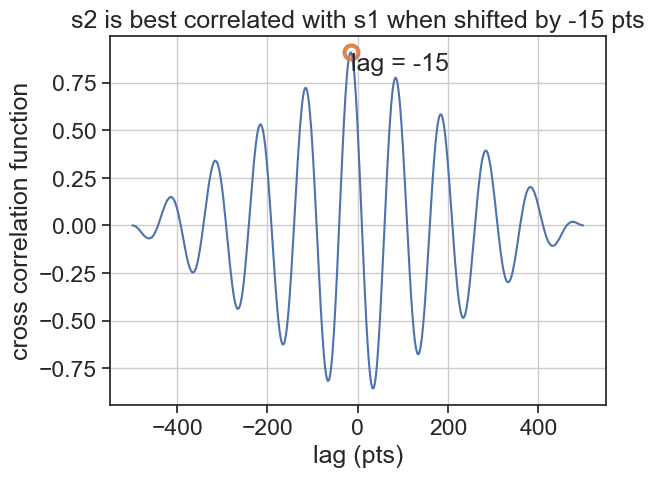

In [7]:
# corr_np = signal.correlate(signal1-signal1.mean(), signal2-signal2.mean())
corr_np = signal.correlate(s1, s2) / N
lags = signal.correlation_lags(len(s1), len(s2))
max_index = np.argmax(corr_np)
# print(lags_time[max_index])
fig, ax = plt.subplots()
ax.plot(lags, corr_np)
ax.plot([lags[max_index]], [corr_np[max_index]], ls="None", marker="o", mfc="None", mew=3, ms=10)
ax.text(lags[max_index], corr_np[max_index],
        f"lag = {lags[max_index]}", va="top", ha="left")
ax.grid(True)
ax.set(xlabel="lag (pts)",
       ylabel="cross correlation function",
       title=f"s2 is best correlated with s1 when shifted by {lags[max_index]} pts")

In [8]:
nann = np.zeros(N) * np.nan
s1_padded = np.hstack([nann, s1, nann])
N_padded = len(s1_padded)
lag_padded = np.arange(N_padded) - N
s2_padded = np.hstack([nann, nann, s2, nann, nann])

In [9]:
# Generate some sample data
# x = np.linspace(0, 10, 100)
# y1 = np.sin(x)
# y2_base = np.cos(x)

# Define a function to plot the time series with a shift
def plot_time_series(shift=-500):
    sh = shift + N + 1
    fig, ax = plt.subplots(2, 1, figsize=(8, 6))
    fig.subplots_adjust(hspace=0.3)  # increase vertical space between panels
    ax[0].plot(lag_padded * delta_t, s1_padded, label="normalized 1")
    ax[0].plot(lag_padded * delta_t, s2_padded[2*N-sh:-sh], label="normalized 2", zorder=0)
    ax[0].set(xlabel="time",
           ylabel="normalized signal",
           xlim=[delta_t*lag_padded.min(), delta_t*lag_padded.max()])
    ax[1].plot(lags, corr_np, color="black", alpha=0.2)
    ax[1].plot(lags[:sh], corr_np[:sh], lw=3, color="xkcd:hot pink")
    ax[1].set(xlabel="lag (pts)",
           ylabel="CCF",
           xlim=[lags.min(), lags.max()],
           ylim=[-1,1])

    plt.show()

# Use interact to create the widget
interact(plot_time_series, shift=IntSlider(min=-500, max=499, step=1, value=-500))

# Add custom CSS to change the length of the slider
display(HTML("""
<style>
.widget-slider {
    width: 100%;
}
</style>
"""))

interactive(children=(IntSlider(value=-500, description='shift', max=499, min=-500), Output()), _dom_classes=(…